In [1]:
from tensorflow.keras.applications import VGG19, DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout,Conv2D, BatchNormalization,Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import cv2 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import eli5
from eli5.sklearn import PermutationImportance
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pprint
from collections import deque
import copy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from sklearn.utils import shuffle

2025-12-18 21:28:20.355439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766093300.797163      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766093300.936743      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Project Setup and Data Loading

In [2]:
base_path = "/kaggle/input/chest-xray-covid19-pneumonia"
categories = ['NORMAL', 'COVID19', 'PNEUMONIA']
image_size = (224,224)

In [3]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [4]:
# Load training data

train_path = os.path.join(base_path, 'Data', 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/NORMAL...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/COVID19...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA...


In [5]:
# Load test data
test_path = os.path.join(base_path, 'Data', 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/NORMAL...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA...


In [6]:
img_shape = (224, 224, 3)
num_classes = 3

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [9]:
label_mapping = {'COVID19': 0, 'PNEUMONIA': 1,'NORMAL': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_int, num_classes).astype('float32')
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_int, num_classes).astype('float32')

# Variables of PSO and Whale Optimization Technique

In [10]:
PSO_PARTICLES = 2  
PSO_ITERATIONS = 2  
CNN_EPOCHS = 2   
WOA_WHALES = 2        
WOA_ITERATIONS = 2 

# CNN Model

In [11]:
ULTIMATE_BEST_PARAMS = None
ULTIMATE_BEST_ACCURACY = -1.0

In [12]:
def build_cnn_model(params):
    model = Sequential()
    model.add(Input(shape=img_shape))
    
    n_conv = int(params['n_conv_layers'])
    filters = int(params['conv_filters'])
    
    for _ in range(n_conv):
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(int(params['dense_units_1']), activation='relu'))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(int(params['dense_units_2']), activation='relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# PSO to optimize model's hyperparamter

In [13]:
pso_bounds = [
    (1e-5, 1e-3), # Learning Rate
    (16, 64),     # Batch Size
    (32, 64),     # Conv Filters
    (1, 3),       # Num Conv Layers
    (64, 128),    # Dense 1 Units
    (32, 64),     # Dense 2 Units
    (0.1, 0.5)    # Dropout Rate
]

In [14]:
class Particle:
    def __init__(self, bounds):
        self.position = []
        self.velocity = []
        self.best_position = []
        self.best_score = -1.0 
        
        for low, high in bounds:
            val = np.random.uniform(low, high)
            self.position.append(val)
            self.velocity.append(0.0)
            self.best_position.append(val)

In [15]:
def run_pso_optimization(c1, c2, whale_id, woa_iter):
    global ULTIMATE_BEST_PARAMS, ULTIMATE_BEST_ACCURACY
    swarm = [Particle(pso_bounds) for _ in range(PSO_PARTICLES)]
    global_best_pos = None
    global_best_score = -1.0

    for pso_iter in range(PSO_ITERATIONS):
        print(f"      > [PSO Iter {pso_iter+1}/{PSO_ITERATIONS}] Optimizing CNNs...")
        
        for p_idx, p in enumerate(swarm):
            params = {
                'learning_rate': p.position[0],
                'batch_size':    int(p.position[1]),
                'conv_filters':  int(p.position[2]),
                'n_conv_layers': int(p.position[3]),
                'dense_units_1': int(p.position[4]),
                'dense_units_2': int(p.position[5]),
                'dropout_rate':  p.position[6]
            }
            
            accuracy = 0.0
            model = build_cnn_model(params)
            
            for epoch in range(CNN_EPOCHS):
                history = model.fit(
                    train_images, train_labels_one_hot,
                    batch_size=int(params['batch_size']),
                    epochs=1,
                    verbose=0 
                )
                acc = history.history['accuracy'][0]
                
                print(f"        - [Particle {p_idx+1}/{PSO_PARTICLES}] Epoch {epoch+1}/{CNN_EPOCHS} | Accuracy: {acc:.4f}")
            loss, accuracy = model.evaluate(train_images, train_labels_one_hot, verbose=0)
            
            del model
            tf.keras.backend.clear_session()

            if accuracy > p.best_score:
                p.best_score = accuracy
                p.best_position = p.position.copy()
            
            if accuracy > global_best_score:
                global_best_score = accuracy
                global_best_pos = p.position.copy()

                if global_best_score > ULTIMATE_BEST_ACCURACY:
                    ULTIMATE_BEST_ACCURACY = global_best_score
                    ULTIMATE_BEST_PARAMS = params.copy()
        
        if global_best_pos is not None:
            for p in swarm:
                for i in range(len(p.position)):
                    r1, r2 = np.random.rand(), np.random.rand()
                    cognitive = c1 * r1 * (p.best_position[i] - p.position[i])
                    social    = c2 * r2 * (global_best_pos[i] - p.position[i])
                    p.velocity[i] = 0.5 * p.velocity[i] + cognitive + social
                    p.position[i] = np.clip(p.position[i] + p.velocity[i], pso_bounds[i][0], pso_bounds[i][1])

    return global_best_score

# Whale optimizer to optimize C1, C2 of PSO 

In [16]:
woa_lb = [0.5, 0.5] # Lower bound for C1, C2
woa_ub = [2.5, 2.5] # Upper bound for C1, C2
dim = 2 

In [17]:
def fitness_function_woa(whale_position, whale_id):
    c1 = whale_position[0]
    c2 = whale_position[1]

    print(f"    ------------------------------------------------------")
    print(f"    [Whale {whale_id+1}/{WOA_WHALES}] Testing Strategy: C1={c1:.2f}, C2={c2:.2f}")
    
    accuracy = run_pso_optimization(c1, c2, whale_id, 0) 
    
    print(f"    [Whale {whale_id+1}/{WOA_WHALES}] Result: Best CNN Accuracy = {accuracy*100:.2f}%")
    
    return 1.0 - accuracy

In [18]:
whales = np.random.rand(WOA_WHALES, dim)
for i in range(dim):
    whales[:, i] = woa_lb[i] + whales[:, i] * (woa_ub[i] - woa_lb[i])

# STARTING OPTIMIZATION HIERARCHY
# (Whale) -> controls -> Manager (PSO) -> controls -> Worker (CNN)

In [19]:
best_whale_pos = whales[0]
best_whale_error = 1.0 

for t in range(WOA_ITERATIONS):
    print(f"\n--- Whale Iteration {t+1}/{WOA_ITERATIONS} ---")
    a = 2 - t * (2 / WOA_ITERATIONS)
    
    for i in range(WOA_WHALES):
        whales[i] = np.clip(whales[i], woa_lb, woa_ub)
        
        current_error = fitness_function_woa(whales[i], i)
        
        if current_error < best_whale_error:
            best_whale_error = current_error
            best_whale_pos = whales[i].copy()
            print(f"    *** NEW GLOBAL BEST! C1={best_whale_pos[0]:.2f}, C2={best_whale_pos[1]:.2f} ***")

    for i in range(WOA_WHALES):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        A = 2 * a * r1 - a
        C = 2 * r2
        p = np.random.rand()
        
        if p < 0.5:
            if np.abs(A).all() < 1:
                D = np.abs(C * best_whale_pos - whales[i])
                whales[i] = best_whale_pos - A * D
            else:
                rand_whale = whales[np.random.randint(0, WOA_WHALES)]
                D = np.abs(C * rand_whale - whales[i])
                whales[i] = rand_whale - A * D
        else:
            D = np.abs(best_whale_pos - whales[i])
            whales[i] = D * np.exp(1 * np.random.uniform(-1, 1)) * np.cos(2 * np.pi * np.random.uniform(-1, 1)) + best_whale_pos



--- Whale Iteration 1/2 ---
    ------------------------------------------------------
    [Whale 1/2] Testing Strategy: C1=2.27, C2=1.94
      > [PSO Iter 1/2] Optimizing CNNs...


I0000 00:00:1766093489.161000      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766093489.161609      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1766093499.530815     110 service.cc:148] XLA service 0x7f05b8006510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766093499.532511     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766093499.532540     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766093499.923506     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1766093504.902829     110 device_compiler.h:188] Compiled clust

        - [Particle 1/2] Epoch 1/2 | Accuracy: 0.8225
        - [Particle 1/2] Epoch 2/2 | Accuracy: 0.9244
        - [Particle 2/2] Epoch 1/2 | Accuracy: 0.8248
        - [Particle 2/2] Epoch 2/2 | Accuracy: 0.9320
      > [PSO Iter 2/2] Optimizing CNNs...
        - [Particle 1/2] Epoch 1/2 | Accuracy: 0.8351
        - [Particle 1/2] Epoch 2/2 | Accuracy: 0.9228
        - [Particle 2/2] Epoch 1/2 | Accuracy: 0.8112
        - [Particle 2/2] Epoch 2/2 | Accuracy: 0.9203
    [Whale 1/2] Result: Best CNN Accuracy = 97.14%
    *** NEW GLOBAL BEST! C1=2.27, C2=1.94 ***
    ------------------------------------------------------
    [Whale 2/2] Testing Strategy: C1=0.72, C2=2.35
      > [PSO Iter 1/2] Optimizing CNNs...
        - [Particle 1/2] Epoch 1/2 | Accuracy: 0.7031
        - [Particle 1/2] Epoch 2/2 | Accuracy: 0.8381
        - [Particle 2/2] Epoch 1/2 | Accuracy: 0.8303
        - [Particle 2/2] Epoch 2/2 | Accuracy: 0.9378
      > [PSO Iter 2/2] Optimizing CNNs...
        - [Particle

In [20]:
print("\n--- FINAL RESULTS ---")
print(f"Best C1 found: {best_whale_pos[0]:.4f}")
print(f"Best C2 found: {best_whale_pos[1]:.4f}")
print(f"Best parameters: {ULTIMATE_BEST_PARAMS}")
print(f"Best accuracy: {ULTIMATE_BEST_ACCURACY}")


--- FINAL RESULTS ---
Best C1 found: 0.7207
Best C2 found: 2.3460
Best parameters: {'learning_rate': 0.0007144300754317205, 'batch_size': 21, 'conv_filters': 54, 'n_conv_layers': 1, 'dense_units_1': 108, 'dense_units_2': 46, 'dropout_rate': 0.20922799682139792}
Best accuracy: 0.9722006320953369


# Retraining Model using best parameters

In [21]:
if ULTIMATE_BEST_PARAMS is None:
    print("Optimization not run or failed. Using default parameters.")
    best_params = {'learning_rate': 1e-4, 'batch_size': 32, 'conv_filters': 32, 
                   'n_conv_layers': 2, 'dense_units_1': 64, 'dense_units_2': 32, 
                   'dropout_rate': 0.3}
else:
    best_params = ULTIMATE_BEST_PARAMS

In [22]:
final_model = build_cnn_model(best_params)

final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [23]:
print("Training final model to capture history...")
final_history = final_model.fit(
    train_images, train_labels_one_hot,
    batch_size=int(best_params['batch_size']),
    epochs=5,
    validation_split=0.15,
    verbose=1
)

Training final model to capture history...
Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7063 - loss: 3.0566 - precision: 0.7155 - recall: 0.6848 - val_accuracy: 0.9184 - val_loss: 0.2177 - val_precision: 0.9205 - val_recall: 0.9145
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9273 - loss: 0.2087 - precision: 0.9313 - recall: 0.9246 - val_accuracy: 0.9326 - val_loss: 0.1971 - val_precision: 0.9362 - val_recall: 0.9313
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9527 - loss: 0.1172 - precision: 0.9548 - recall: 0.9521 - val_accuracy: 0.9456 - val_loss: 0.1705 - val_precision: 0.9455 - val_recall: 0.9443
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9760 - loss: 0.0734 - precision: 0.9768 - recall: 0.9751 - val_accuracy: 0.9430 - val_loss: 0.1771 - val_precision: 0.9429 - val_recall: 0.9417
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9904 - loss: 0.0356 - precision: 0.9908 - recall: 

In [24]:
print("\nGenerating Predictions for Plots...")
y_pred_probs = final_model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)


Generating Predictions for Plots...
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


# Plottings

* Confusion Matrix
* Roc Curve
* Training & Validation history
* Validation history
* Percision & Recall 


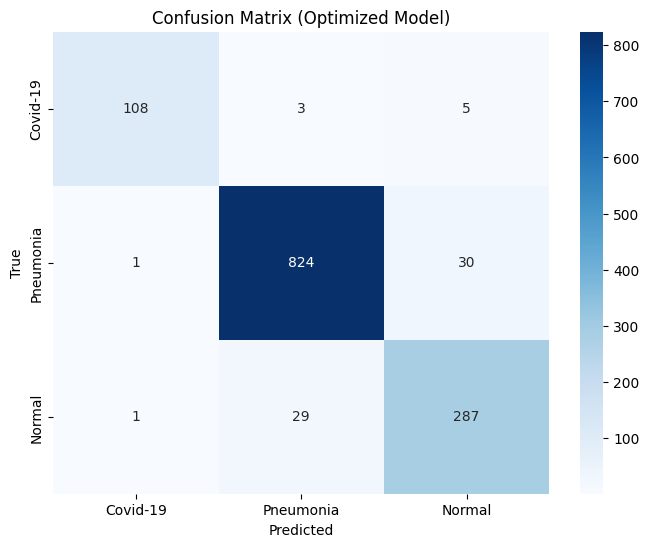

In [25]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
            yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
plt.title('Confusion Matrix (Optimized Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

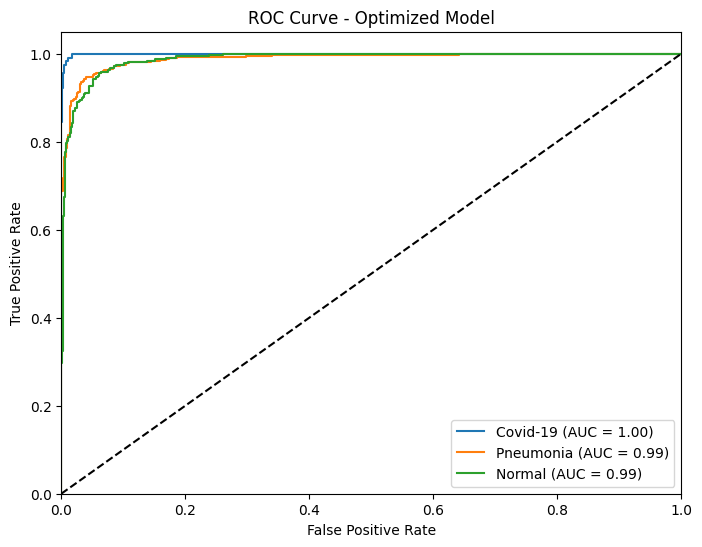

In [26]:
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    # Calculate ROC for each class
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot
    class_name = ['Covid-19', 'Pneumonia', 'Normal'][i]
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized Model')
plt.legend(loc="lower right")
plt.show()

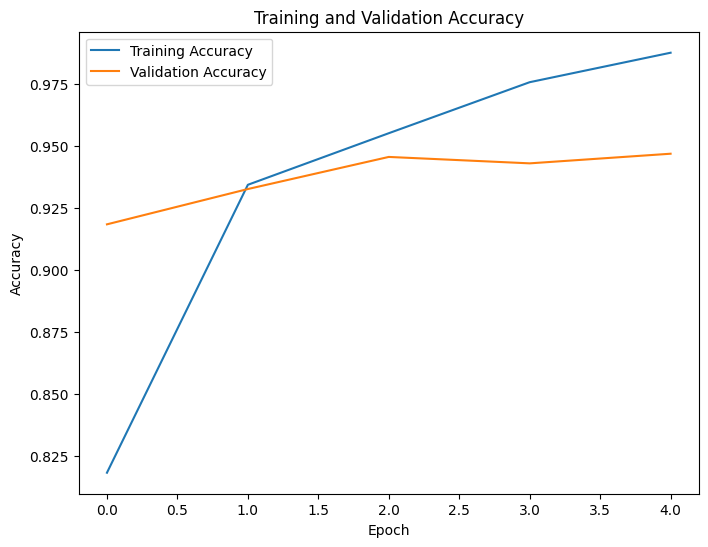

In [27]:
history_keys = final_history.history.keys()

# 1. Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

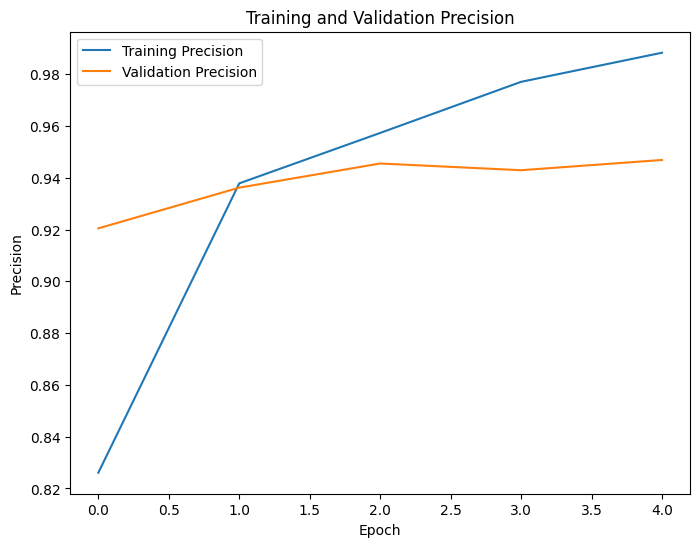

In [28]:
if 'precision' in history_keys:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['precision'], label='Training Precision')
    plt.plot(final_history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

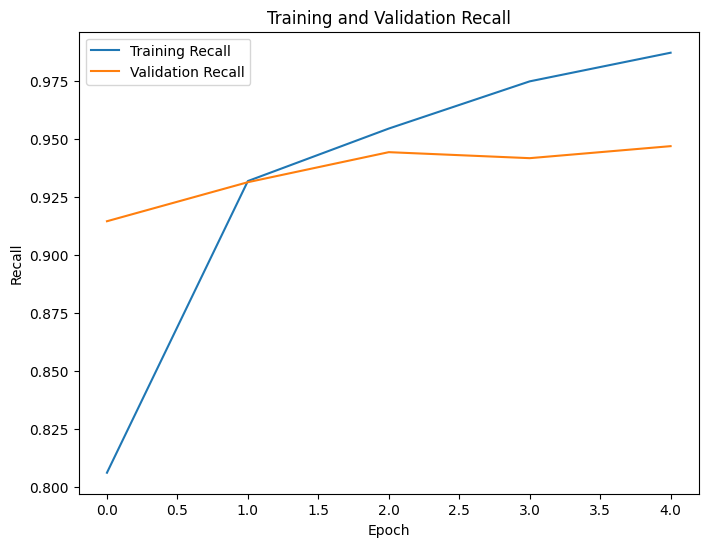

In [29]:
if 'recall' in history_keys:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['recall'], label='Training Recall')
    plt.plot(final_history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

# XAI Optimization

# Permutation importance

In [30]:
def get_permutation_importance_map(model, image, class_index, patch_size):
    patch_size = max(4, min(int(patch_size), 64))
    
    img_batch = np.expand_dims(image, axis=0)
    baseline_prob = model.predict(img_batch, verbose=0)[0, class_index]
    
    h, w, _ = image.shape
    heatmap = np.zeros((h, w))
    
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            perturbed_img = image.copy()
            
            # Replace current patch with random noise
            noise = np.random.rand(patch_size, patch_size, 3)
            perturbed_img[i:i+patch_size, j:j+patch_size, :] = noise
            
            # Get prediction on perturbed image
            pred_prob = model.predict(np.expand_dims(perturbed_img, axis=0), verbose=0)[0, class_index]
            
            # Calculate importance: how much did prediction drop?
            importance = max(0, baseline_prob - pred_prob)
            
            # Store importance in heatmap
            heatmap[i:i+patch_size, j:j+patch_size] = importance
    
    # Normalize heatmap to 0-1 range
    if heatmap.max() > 0: 
        heatmap /= heatmap.max()
    
    return heatmap

In [31]:
def calculate_faithfulness_score(model, image, heatmap, class_index):
    # Identify the top 20% most important regions
    threshold = np.percentile(heatmap, 80)
    mask = (heatmap >= threshold).astype(np.float32)
    mask = np.expand_dims(mask, axis=2)
    
    # Mask those regions (multiply by (1-mask) to black them out)
    masked_image = image * (1 - mask)
    
    # Get predictions
    orig_prob = model.predict(np.expand_dims(image, axis=0), verbose=0)[0, class_index]
    new_prob = model.predict(np.expand_dims(masked_image, axis=0), verbose=0)[0, class_index]
    
    # Return the drop in probability
    return orig_prob - new_prob

In [32]:
XAI_DIM = 1  # We optimize 1 parameter per method
XAI_LB = [0]  # Lower bound (will be scaled)
XAI_UB = [1]  # Upper bound (will be scaled)
XAI_ITER = 3  # Number of optimization iterations
XAI_POP = 3   # Population size

In [33]:
def fitness_function_permutation(params, algorithm_name, model, image, class_idx):
    patch_size = 4 + (params[0] * 60)
    
    try:
        # Generate explanation
        heatmap = get_permutation_importance_map(model, image, class_idx, patch_size)
        
        # Calculate faithfulness
        score = calculate_faithfulness_score(model, image, heatmap, class_idx)
    except:
        score = -1.0
    
    print(f"    [{algorithm_name}] Permutation Patch Size={patch_size:.1f} -> Faithfulness: {score:.4f}")
    return score

In [34]:
#Use Whale Optimization Algorithm to find best patch_size for Permutation Importance.
def run_woa_permutation(model, image, c_idx):
    X = np.random.rand(XAI_POP, XAI_DIM)
    Best_X, Best_Score = np.zeros(XAI_DIM), -1
    
    for t in range(XAI_ITER):
        a = 2 - t * (2/XAI_ITER)
        for i in range(XAI_POP):
            X[i] = np.clip(X[i], XAI_LB, XAI_UB)
            score = fitness_function_permutation(X[i], "WOA", model, image, c_idx)
            if score > Best_Score: 
                Best_Score, Best_X = score, X[i].copy()
        
        for i in range(XAI_POP):
            r1, r2, p = np.random.rand(XAI_DIM), np.random.rand(XAI_DIM), np.random.rand()
            A, C = 2*a*r1 - a, 2*r2
            if p < 0.5:
                if np.abs(A).mean() < 1: 
                    X[i] = Best_X - A*np.abs(C*Best_X - X[i])
                else: 
                    X[i] = X[np.random.randint(0, XAI_POP)] - A*np.abs(C*X[np.random.randint(0, XAI_POP)] - X[i])
            else: 
                X[i] = np.abs(Best_X - X[i]) * np.exp(np.random.uniform(-1,1)) * np.cos(2*np.pi*np.random.uniform(-1,1)) + Best_X
    
    return Best_X, Best_Score

In [35]:
# GWO for Permutation Importance
def run_gwo_permutation(model, image, c_idx):
    Alpha_pos, Beta_pos, Delta_pos = np.zeros(XAI_DIM), np.zeros(XAI_DIM), np.zeros(XAI_DIM)
    Alpha_score, Beta_score, Delta_score = -float('inf'), -float('inf'), -float('inf')
    X = np.random.rand(XAI_POP, XAI_DIM)
    
    for t in range(XAI_ITER):
        a = 2 - t * (2/XAI_ITER)
        for i in range(XAI_POP):
            X[i] = np.clip(X[i], XAI_LB, XAI_UB)
            score = fitness_function_permutation(X[i], "GWO", model, image, c_idx)
            if score > Alpha_score: 
                Delta_score, Delta_pos = Beta_score, Beta_pos.copy()
                Beta_score, Beta_pos = Alpha_score, Alpha_pos.copy()
                Alpha_score, Alpha_pos = score, X[i].copy()
            elif score > Beta_score: 
                Delta_score, Delta_pos = Beta_score, Beta_pos.copy()
                Beta_score, Beta_pos = score, X[i].copy()
            elif score > Delta_score: 
                Delta_score, Delta_pos = score, X[i].copy()
        
        for i in range(XAI_POP):
            for j in range(XAI_DIM):
                X1 = Alpha_pos[j] - (2*a*np.random.rand()-a) * abs(2*np.random.rand()*Alpha_pos[j] 
                X2 = Beta_pos[j] - (2*a*np.random.rand()-a) * abs(2*np.random.rand()*Beta_pos[j] - X[i,j])
                X3 = Delta_pos[j] - (2*a*np.random.rand()-a) * abs(2*np.random.rand()*Delta_pos[j] - X[i,j])
                X[i,j] = (X1 + X2 + X3) / 3
    
    return Alpha_pos, Alpha_score

In [36]:
sample_idx = 0
demo_img = test_images[sample_idx]

pred_probs = final_model.predict(np.expand_dims(demo_img, axis=0), verbose=0)
target_class_idx = np.argmax(pred_probs)

In [37]:
print("\n========== OPTIMIZING PERMUTATION IMPORTANCE ==========")
woa_perm_params, woa_perm_score = run_woa_permutation(final_model, demo_img, target_class_idx)
gwo_perm_params, gwo_perm_score = run_gwo_permutation(final_model, demo_img, target_class_idx)


========== OPTIMIZING PERMUTATION IMPORTANCE ==========
    [WOA] Permutation Patch Size=24.2 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=7.6 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=23.0 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=4.0 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=9.9 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=4.0 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=9.2 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=6.8 -> Faithfulness: 0.9949
    [WOA] Permutation Patch Size=6.8 -> Faithfulness: 0.9949
    [GWO] Permutation Patch Size=50.1 -> Faithfulness: 0.9949
    [GWO] Permutation Patch Size=34.6 -> Faithfulness: 0.9949
    [GWO] Permutation Patch Size=7.1 -> Faithfulness: 0.9949
    [GWO] Permutation Patch Size=39.9 -> Faithfulness: 0.9949
    [GWO] Permutation Patch Size=26.9 -> Faithfulness: 0.9949
    [GWO] Permutation Patch Size=45.3 -> Faithfulness: 0.9947
    [GWO] Permutation

In [43]:
# Calculate patch sizes
woa_patch_size = 4 + (woa_perm_params[0] * 60)
gwo_patch_size = 4 + (gwo_perm_params[0] * 60)

print(f"\n=== FINAL XAI RESULTS ===")
print(f"\nWHALE OPTIMIZATION ALGORITHM (WOA):")
print(f"  Best Patch Size: {woa_patch_size:.1f} pixels")
print(f"  Faithfulness Score: {woa_perm_score:.4f}")

print(f"\nGREY WOLF OPTIMIZER (GWO):")
print(f"  Best Patch Size: {gwo_patch_size:.1f} pixels")
print(f"  Faithfulness Score: {gwo_perm_score:.4f}")


=== FINAL XAI RESULTS ===

WHALE OPTIMIZATION ALGORITHM (WOA):
  Best Patch Size: 7.6 pixels
  Faithfulness Score: 0.9949

GREY WOLF OPTIMIZER (GWO):
  Best Patch Size: 7.1 pixels
  Faithfulness Score: 0.9949


In [45]:
print("\n=== Generating 4-Panel Visualization ===")

class_names = ['COVID19', 'PNEUMONIA', 'NORMAL']

# Calculate patch sizes
default_patch_size = 32  # Default unoptimized

# Generate heatmaps for ALL three versions
print("Generating default heatmap...")
default_heatmap = get_permutation_importance_map(final_model, demo_img, target_class_idx, default_patch_size)

print("Generating WOA optimized heatmap...")
woa_heatmap = get_permutation_importance_map(final_model, demo_img, target_class_idx, woa_patch_size)

print("Generating GWO optimized heatmap...")
gwo_heatmap = get_permutation_importance_map(final_model, demo_img, target_class_idx, gwo_patch_size)


=== Generating 4-Panel Visualization ===
Generating default heatmap...
Generating WOA optimized heatmap...
Generating GWO optimized heatmap...


In [46]:
def get_top_regions_contours(heatmap, threshold_percentile=80):
    """Extract contours of top important regions"""
    threshold = np.percentile(heatmap, threshold_percentile)
    mask = (heatmap >= threshold).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [47]:
# Get contours for all three
contours_default = get_top_regions_contours(default_heatmap)
contours_woa = get_top_regions_contours(woa_heatmap)
contours_gwo = get_top_regions_contours(gwo_heatmap)

# Prepare images for display
demo_img_display = (demo_img * 255).astype(np.uint8)
overlay_default = demo_img_display.copy()
overlay_woa = demo_img_display.copy()
overlay_gwo = demo_img_display.copy()

# Draw yellow contours
cv2.drawContours(overlay_default, contours_default, -1, (255, 255, 0), 2)
cv2.drawContours(overlay_woa, contours_woa, -1, (255, 255, 0), 2)
cv2.drawContours(overlay_gwo, contours_gwo, -1, (255, 255, 0), 2)

array([[[255, 255,   0],
        [255, 255,   0],
        [255, 255,   0],
        ...,
        [108, 108, 108],
        [114, 114, 114],
        [110, 110, 110]],

       [[255, 255,   0],
        [255, 255,   0],
        [255, 255,   0],
        ...,
        [113, 113, 113],
        [112, 112, 112],
        [115, 115, 115]],

       [[255, 255,   0],
        [255, 255,   0],
        [135, 135, 135],
        ...,
        [117, 117, 117],
        [111, 111, 111],
        [114, 114, 114]],

       ...,

       [[ 67,  67,  67],
        [ 72,  72,  72],
        [ 77,  77,  77],
        ...,
        [139, 139, 139],
        [132, 132, 132],
        [129, 129, 129]],

       [[ 68,  68,  68],
        [ 73,  73,  73],
        [ 77,  77,  77],
        ...,
        [141, 141, 141],
        [134, 134, 134],
        [125, 125, 125]],

       [[ 66,  66,  66],
        [ 72,  72,  72],
        [ 77,  77,  77],
        ...,
        [143, 143, 143],
        [138, 138, 138],
        [124, 124, 124]]

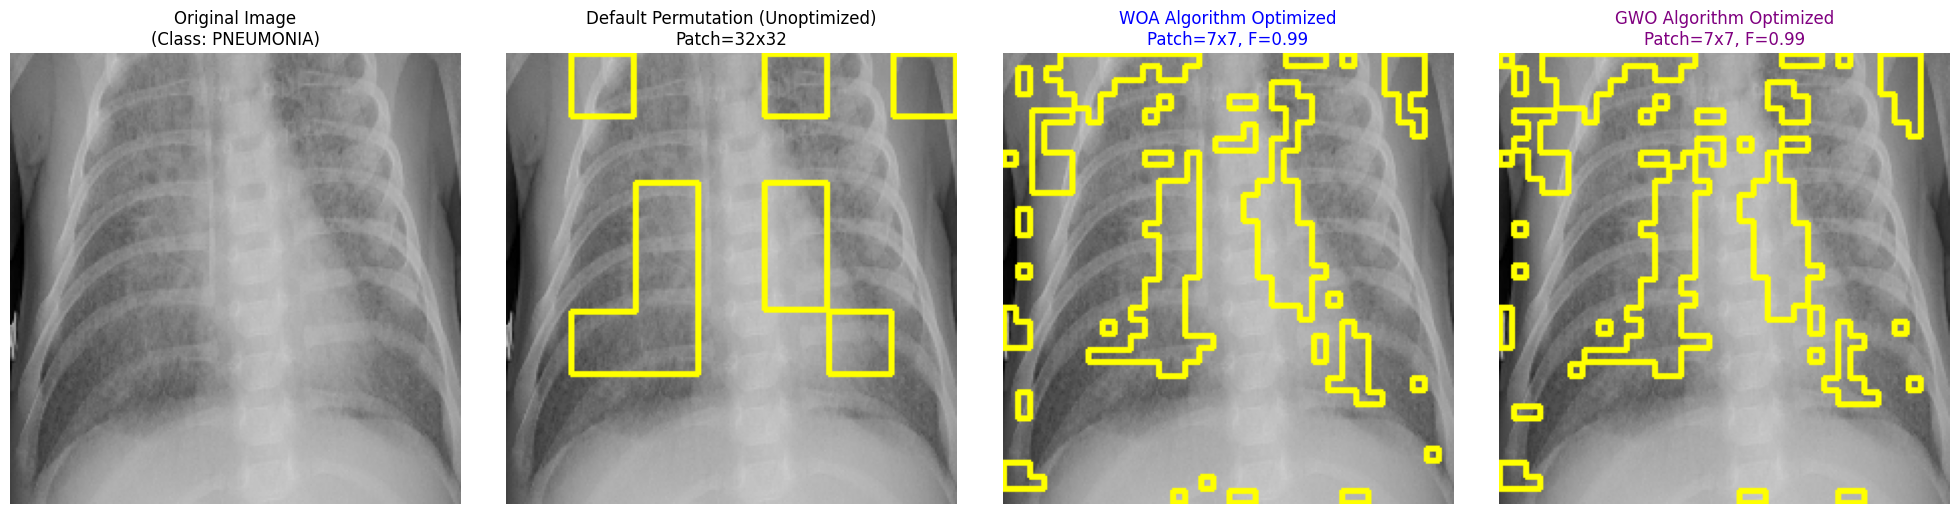


✓ Visualization saved as 'permutation_importance_woa_gwo_comparison.png'

*** WINNER: GWO with Faithfulness Score 0.9949 ***


In [48]:
# Create 4-panel figure
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Panel 1: Original Image
axes[0].imshow(demo_img_display)
axes[0].set_title(f'Original Image\n(Class: {class_names[target_class_idx]})', fontsize=12)
axes[0].axis('off')

# Panel 2: Default (Unoptimized)
axes[1].imshow(overlay_default)
axes[1].set_title(f'Default Permutation (Unoptimized)\nPatch={int(default_patch_size)}x{int(default_patch_size)}', fontsize=12)
axes[1].axis('off')

# Panel 3: WOA Optimized
axes[2].imshow(overlay_woa)
axes[2].set_title(f'WOA Algorithm Optimized\nPatch={int(woa_patch_size)}x{int(woa_patch_size)}, F={woa_perm_score:.2f}', 
                 fontsize=12, color='blue')
axes[2].axis('off')


axes[3].imshow(overlay_gwo)
axes[3].set_title(f'GWO Algorithm Optimized\nPatch={int(gwo_patch_size)}x{int(gwo_patch_size)}, F={gwo_perm_score:.2f}', 
                 fontsize=12, color='purple')
axes[3].axis('off')

plt.tight_layout()
plt.savefig('permutation_importance_woa_gwo_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'permutation_importance_woa_gwo_comparison.png'")

# Determine winner
if woa_perm_score > gwo_perm_score:
    print(f"\n*** WINNER: WOA with Faithfulness Score {woa_perm_score:.4f} ***")
else:
    print(f"\n*** WINNER: GWO with Faithfulness Score {gwo_perm_score:.4f} ***")
